In [1]:
import torch
import os
import numpy as np
import matplotlib.pyplot as plt

In [49]:
evaluation_path = os.path.join("..","evaluation","iresnet50_evaluation.pth")

In [50]:
evaluation = torch.load(evaluation_path,map_location=torch.device('cpu') )

In [51]:
def get_roc(impostor_scores_dict: dict, pair_scores_dict: dict, number_of_points: int = 1000):
    impostor = np.array([impostor_scores_dict[key] for key in impostor_scores_dict])
    pair = np.array([pair_scores_dict[key] for key in pair_scores_dict])
    min_score = min(impostor.min(), pair.min())
    max_score = min(impostor.max(), pair.max())
    print(f"Impostor (min,max): ({impostor.min()}, {impostor.max()})")
    print(f"Pair (min,max): ({pair.min()}, {pair.max()})")
    impostor_hist = np.histogram(impostor,density=True)
    pair_hist = np.histogram(pair,density=True)
    
    t_range = np.arange(min_score, max_score, (max_score - min_score)/number_of_points)
    points = []
    for t in t_range:
        fmr = np.average(impostor >= t)
        fnmr = np.average(pair <= t)
        points.append((fmr, fnmr))
    return np.array(points), t_range, impostor_hist, pair_hist


In [52]:
fmr_at_fnmr, t_range, impostor_hist, pair_hist = get_roc(evaluation['impostor_scores']['cosine'], evaluation['pair_scores']['cosine'])

Impostor (min,max): (-0.21467609703540802, 1.0)
Pair (min,max): (-0.1765071153640747, 1.0)


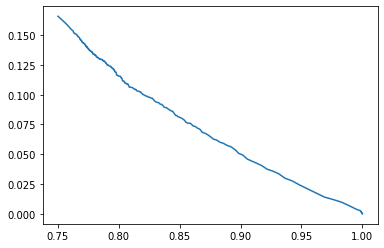

In [53]:
plt.plot(fmr_at_fnmr[:,0],fmr_at_fnmr[:,1])

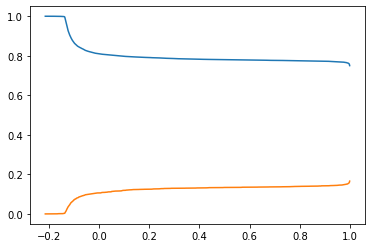

In [54]:
plt.plot(t_range, fmr_at_fnmr[:,0])
plt.plot(t_range, fmr_at_fnmr[:,1])

Histogrmams


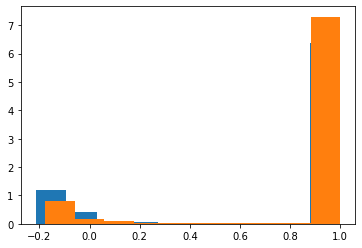

In [55]:
plt.hist(impostor_hist[1][:-1], impostor_hist[1], weights=impostor_hist[0])
plt.hist(pair_hist[1][:-1], pair_hist[1], weights=pair_hist[0])
print("Histogrmams")